In [88]:
import credentials # Api key is stored in this file, remove to avoid errors if you clone from github

import pvdeg
import pvlib
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy.linalg import cholesky
# from math import e as euler

First get weather data and metadata for a desired location (latitude and logitude)

In [89]:
# change to desired values (currently Miami)
latitude = 25.783388
longitude = -80.189029

API_KEY = credentials.API_KEY # my personal NREL api key
email ='tobin.ford@nrel.gov' # replace these values with your appropriate information and remove or comment out first line of first block (import credentials)

# reads NSRDB data 
weather_df, meta = pvlib.iotools.get_psm3(latitude, longitude, API_KEY, email, names='2019', map_variables=True)

c:\ProgramData\anaconda3\lib\site-packages\pvlib\iotools\psm3.py:185: pvlibDeprecationWarning: The ``get_psm3`` function will default to leap_day=True starting in pvlib 0.11.0. Specify leap_day=True to enable this behavior now, or specify leap_day=False to hide this warning.
  warnings.warn(


User has 3 parameters for initial implementation: See Kempe's "Deg Miami" tab in excel<br>



activation energy, Ea <br>
irradiance relation, x<br>
ln(R0)<br>

          *________________________________________*
          |             |            |             |
    Ea    |       1     |      a     |      b      |
          __________________________________________
          |             |            |             |
    x     |      a      |     1      |      c      |
          __________________________________________
          |             |            |             |
  ln(R0)  |      b      |     c      |      1      |
          __________________________________________
          *     Ea            X           ln(R0)   *

Notice symmetry across diagonal <br>

In [90]:
# USER ENTERED VALUES
# Correlation Coefficients
Ea_X = 0.0269
Ea_lnR0 = -0.9995
X_lnR0 = -0.0400

# Activation Energy
mean_Ea = 129 # average
sd_Ea = 3.4 # standard deviation

# Irradiance relation
mean_X = 0.0341 # average
sd_X = 0.0992757 # standard deviation

# ln(R0)
mean_R0 = 13.7223084 
sd_R0 = 2.47334772

# number of iterations
n = 20000


In [91]:
# notice symmetry of matrix
A = np.array([[1, Ea_X, Ea_lnR0],
              [Ea_X, 1, X_lnR0],
              [Ea_lnR0, X_lnR0, 1]])

# conceptually similar to the square root of a matrix
A_decomp = cholesky(A, lower=True)

# generating standard distribution of points for each
Ea, X, R0 = np.random.normal(mean_Ea, sd_Ea, 20_000), np.random.normal(mean_X, sd_X, 20_000), np.random.normal(mean_R0, sd_R0, 20_000)

# transpose built in so I don't have to do it with another function
samples_matrix = np.array([Ea, X, R0])



In [92]:
# correlated stats pre-input to function

# not entirely sure what I should do here,
# do i multiply the transpose by the lower cholesky to get correlated input data for the equation on the spreadsheet
# using MonteCarloEaLnRoX

# this gives us correlated input samples
# looks like what kempe's code was doing in "MonteCarloEaLnRoX" but it is hard to tell what's happening in his code
correlated_samples = np.matmul(A_decomp, samples_matrix)

correlated_df = pd.DataFrame(correlated_samples.T, columns=['Ea', 'X', 'R0'])

# is back tracking on by default
sol_pos = pvdeg.spectral.solar_position(weather_df, meta)
poa_irradiance = pvdeg.spectral.poa_irradiance(weather_df, meta)
temp_mod = pvdeg.temperature.module(weather_df=weather_df, meta=meta, poa=poa_irradiance, conf='open_rack_glass_polymer')
# we only care about global irradiance in this case


In [93]:
print(sol_pos.size)
print(poa_irradiance.size)
print(temp_mod.size)

# these are different sizes so wont that cause an issue when calculating each sample

52560
43800
8760


In [94]:
print(correlated_df)

               Ea         X          R0
0      131.061779  3.712187 -130.673392
1      130.921987  3.343611 -130.601221
2      125.390788  3.608474 -124.958806
3      133.772241  3.703586 -133.285055
4      129.752742  3.507665 -129.302285
...           ...       ...         ...
19995  126.151505  3.504283 -125.716510
19996  137.574538  3.648295 -137.139466
19997  132.549605  3.666610 -132.214291
19998  129.608533  3.510426 -129.134668
19999  125.441292  3.315483 -125.028220

[20000 rows x 3 columns]


In [95]:
# list comprehension 
# want to map this behavior to the main part of the function
A = [(weather_df['ghi'] / x).mean() for x in correlated_df['X']]

len(A)

20000

In [128]:
def mikeArrhenius(weather_df, samples):
# Ea1 = Ea(Z) / 8.31446261815324E-03 'This reduces the amount of calculations in the loop
# Degradation(Z) = Degradation(Z) + Exp(LnRo(Z)) * Exp(-Ea1 / (273.15 + T(Y, 1))) * ((Irr(Y, 1) / 1000) ^ X(Z))


    # FUNCTION for x,y,z in zip(correlated_df['X'], correlated_df['Ea'], corrleated_df['R0'])
    d = np.exp(samples['R0']) * np.exp((samples['Ea'] / 8.31446261815324E-03) / (273.15 + weather_df['temp_air'])) * (weather_df['ghi'] / 1000 ** samples['X'])


    #d.mean()
    
    return pd.DataFrame(d)

In [129]:
def mikeArrhenius2(weather_df, samples): # not using argument properly, it didnt like when i did this

    #['Ea', 'X', 'R0']
    # d = [(np.exp(z) * np.exp((x / 8.31446261815324E-03) / (273.15 + weather_df['temp_air'])) * (weather_df['ghi'] / 1000 ** y)).mean() for x, y, z in zip(correlated_df['Ea'], correlated_df['X'], correlated_df['R0'])]
    d = [(np.exp(z) * np.exp((x / 8.31446261815324E-03) / (273.15 + weather_df['temp_air'])) * (weather_df['ghi'] / 1000 ** y)) for x, y, z in zip(correlated_df['Ea'], correlated_df['X'], correlated_df['R0'])]

    return pd.DataFrame(d)

In [130]:
temp1 = mikeArrhenius(weather_df=weather_df, samples=correlated_df.iloc[0]) # works mostly as desired
# 8760 entries

temp2 = mikeArrhenius2(weather_df=weather_df, samples=correlated_df.iloc[0]) # gets mad if i pass as value
# 175200000 entries, something is wrong here
# 175200000 / 8760 = 20,000
# why is this happening 
# change back to numpy array later but dataframes are going to let me understand what is happening better

# difference is probably something about how I am passing values to the functions,
# the original function takes data as arguments but the second just pulls them from globalscope, this is probably causeing some weird behavior

In [133]:
temp1.head(24)

,0
2019-01-01 00:30:00-05:00,0.000000e+00
2019-01-01 01:30:00-05:00,0.000000e+00
2019-01-01 02:30:00-05:00,0.000000e+00
2019-01-01 03:30:00-05:00,0.000000e+00
2019-01-01 04:30:00-05:00,0.000000e+00
2019-01-01 05:30:00-05:00,0.000000e+00
2019-01-01 06:30:00-05:00,0.000000e+00
2019-01-01 07:30:00-05:00,5.827989e-44
2019-01-01 08:30:00-05:00,1.012876e-43
2019-01-01 09:30:00-05:00,4.294592e-43


In [135]:
temp2.head(24) # what does each row represent???, why are there integers (see the function call cell)

,2019-01-01 00:30:00-05:00,2019-01-01 01:30:00-05:00,2019-01-01 02:30:00-05:00,2019-01-01 03:30:00-05:00,2019-01-01 04:30:00-05:00,2019-01-01 05:30:00-05:00,2019-01-01 06:30:00-05:00,2019-01-01 07:30:00-05:00,2019-01-01 08:30:00-05:00,2019-01-01 09:30:00-05:00,...,2019-12-31 14:30:00-05:00,2019-12-31 15:30:00-05:00,2019-12-31 16:30:00-05:00,2019-12-31 17:30:00-05:00,2019-12-31 18:30:00-05:00,2019-12-31 19:30:00-05:00,2019-12-31 20:30:00-05:00,2019-12-31 21:30:00-05:00,2019-12-31 22:30:00-05:00,2019-12-31 23:30:00-05:00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.827989e-44,1.012876e-43,4.294592e-43,...,6.053343e-43,2.934582e-43,2.280773e-43,2.347703e-44,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.551976e-43,1.312646e-42,5.565930e-42,...,7.844439e-42,3.802882e-42,2.955396e-42,3.041776e-43,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.658376e-42,6.387458e-42,2.714511e-41,...,3.808614e-41,1.846367e-41,1.430596e-41,1.465773e-42,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.357502e-44,2.354079e-44,9.970332e-44,...,1.408439e-43,6.827928e-44,5.314512e-44,5.482593e-45,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.556873e-43,9.667857e-43,4.101343e-42,...,5.774818e-42,2.799557e-42,2.174285e-42,2.235699e-43,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.904914e-42,5.059090e-42,2.147273e-41,...,3.020376e-41,1.464239e-41,1.136438e-41,1.167351e-42,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.059870e-42,5.339070e-42,2.268251e-41,...,3.184512e-41,1.543810e-41,1.196680e-41,1.226891e-42,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.844811e-40,6.722942e-40,2.859199e-39,...,4.005680e-39,1.941902e-39,1.503128e-39,1.537793e-40,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.367841e-42,1.109789e-41,4.712046e-41,...,6.623304e-41,3.210892e-41,2.490882e-41,2.556807e-42,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.409982e-41,9.463903e-41,4.025779e-40,...,5.637573e-40,2.733022e-40,2.114877e-40,2.162699e-41,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, '$R_0$')

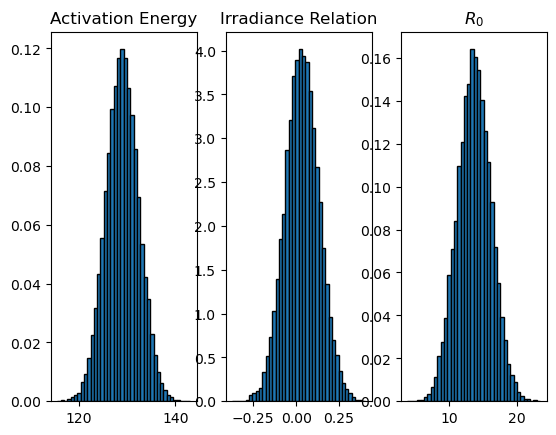

In [82]:
# spot check to view proper distribution
figure, axis = plt.subplots(1, 3)

axis[0].hist(Ea, 40, density=True, edgecolor='black', label='Activation Energy')
axis[0].set_title("Activation Energy")

axis[1].hist(X, 40, density=True, edgecolor='black', label='Activation Energy')
axis[1].set_title("Irradiance Relation")

axis[2].hist(R0, 40, density=True, edgecolor='black', label='Activation Energy')
axis[2].set_title("$R_0$")
